Offline Lambda
---
<img src="illustration.png" width="400">
---
The backup digram for `TD(λ)`. If `λ = 0`, then the overall update reduces to its first component, the one-step TD update, whereas if `λ = 1`, then the overall update reduces to its last component, the Monte Carlo update.
Update Rule
---
<img src="Gtn.png" width="600">
<img src="Gt.png" width="400">
<img src="offline_lambda.png" width="500">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 19 states (not including the ending state)
NUM_STATES = 19
START = 9
END_0 = 0
END_1 = 20

In [3]:
class ValueFunction:
    def __init__(self, alpha=0.1):
        self.weights = np.zeros(NUM_STATES+2)
        self.alpha = alpha
    
    def value(self, state):
        v = self.weights[state]
        return v
    
    def learn(self, state, delta):
        self.weights[state] += self.alpha*delta

In [29]:
class RandomWalk:
    
    def __init__(self, start=START, end=False, lmbda=0.4, debug=False):
        self.actions = ["left", "right"]
        self.state = start  # current state
        self.end = end
        self.lmbda = lmbda
        self.states = []
        self.reward = 0
        self.debug = debug
        self.rate_truncate = 1e-3
                
    def chooseAction(self):    
        action = np.random.choice(self.actions)
        return action 
    
    def takeAction(self, action):
        new_state = self.state
        if not self.end:
            if action == "left":
                new_state = self.state-1
            else:
                new_state = self.state+1
            
            if new_state in [END_0, END_1]:
                self.end = True
        self.state = new_state
        return self.state
    
    def giveReward(self, state):
        if state == END_0:
            return -1
        if state == END_1:
            return 1
        # other states
        return 0
    
    def reset(self):
        self.state = START
        self.end = False
        self.states = []
    
    def gt2tn(self, valueFunc, start, end):
        # only the last reward is non-zero
        reward = self.reward if end == len(self.states)-1 else 0
        state = self.states[end] 
        res = reward + valueFunc.value(state)
        return res
           
    def play(self, valueFunc, rounds=100):
        for _ in range(rounds):
            self.reset()      
            action = self.chooseAction()

            self.states = [self.state]
            while not self.end:
                state = self.takeAction(action)  # next state
                self.reward = self.giveReward(state)  # next state-reward

                self.states.append(state)

                action = self.chooseAction()
            if self.debug:
                print("total states {} end at {} reward {}".format(len(self.states), self.state, self.reward))

            # end of game, do forward update
            T = len(self.states)-1
            for t in range(T):
                # start from time t
                state = self.states[t]
                gtlambda = 0
                for n in range(1, T-t):
                    # compute G_t:t+n
                    gttn = self.gt2tn(valueFunc, t, t+n)
                    lambda_power = np.power(self.lmbda, n-1)
                    gtlambda += lambda_power*gttn
                    if lambda_power < self.rate_truncate:
                        break
                        
                gtlambda *= 1 - self.lmbda
                if lambda_power >= self.rate_truncate:
                    gtlambda += lambda_power*self.reward
                
                delta = gtlambda - valueFunc.value(state)
                valueFunc.learn(state, delta)

In [44]:
valueFunc = ValueFunction(alpha=0.1)
rw = RandomWalk(debug=False, lmbda=0.4)

rw.play(valueFunc, rounds=50)

In [45]:
valueFunc.weights

array([ 0.        , -1.00891022, -1.07904715, -0.87133927, -0.67934023,
       -0.47180329, -0.36555315, -0.25592306, -0.17109379, -0.0260043 ,
        0.06907409,  0.17832788,  0.26504299,  0.37300029,  0.49303013,
        0.6947947 ,  0.76940524,  0.96562993,  1.1660046 ,  1.02847254,
        0.        ])

## Visualisation of Offline-Lambda

In [34]:
actual_state_values = np.arange(-20, 22, 2) / 20.0
actual_state_values[0] = actual_state_values[-1] = 0
actual_state_values

array([ 0. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  0. ])

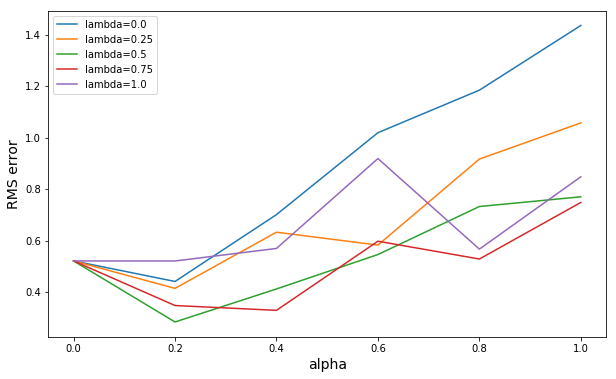

In [48]:
alphas = np.linspace(0, 1, 6)
lambdas = np.linspace(0, 1, 5)
rounds = 50

plt.figure(figsize=[10, 6])
for lamb in lambdas:
    alpha_erros = []
    for alpha in alphas:
        valueFunc = ValueFunction(alpha=alpha)
        rw = RandomWalk(debug=False, lmbda=lamb)
        rw.play(valueFunc, rounds=rounds)
        rmse = np.sqrt(np.mean(np.power(valueFunc.weights - actual_state_values, 2)))
        alpha_erros.append(rmse)
    plt.plot(alphas, alpha_erros, label="lambda={}".format(lamb))

plt.xlabel("alpha", size=14)
plt.ylabel("RMS error", size=14)
plt.legend()

Semi-gradient TD(λ)
---
<img src="TD_lambda.png" width="700">

### TD(λ) improves over the offine λ-return algorithm in three ways 
- First it updates the weight vector on every step of an episode rather than only at the end, and thus its estimates may be better sooner. 
- Second, its computations are equally distributed in time rather than all at the end of the episode. 
- And third, it can be applied to continuing problems rather than just to episodic problems.

In [68]:
class ValueFunctionTD:
    def __init__(self, alpha=0.1, gamma=0.9, lmbda=0.8):
        self.weights = np.zeros(NUM_STATES+2)
        self.z = np.zeros(NUM_STATES+2)
        self.alpha = alpha
        self.gamma = gamma
        self.lmbda = lmbda
        
    def value(self, state):
        v = self.weights[state]
        return v
    
    def updateZ(self, state):
        dev = 1
        self.z *= self.gamma*self.lmbda
        self.z[state] += dev
    
    def learn(self, state, nxtState, reward):
        delta = reward + self.gamma*self.value(nxtState) - self.value(state)
        delta *= self.alpha
        self.weights += delta*self.z

In [84]:
class RWTD:
    
    def __init__(self, start=START, end=False, debug=False):
        self.actions = ["left", "right"]
        self.state = start  # current state
        self.end = end
        self.reward = 0
        self.debug = debug
                
    def chooseAction(self):    
        action = np.random.choice(self.actions)
        return action 
    
    def takeAction(self, action):
        new_state = self.state
        if not self.end:
            if action == "left":
                new_state = self.state-1
            else:
                new_state = self.state+1
            
            if new_state in [END_0, END_1]:
                self.end = True
        return new_state
    
    def giveReward(self, state):
        if state == END_0:
            return -1
        if state == END_1:
            return 1
        # other states
        return 0
    
    def reset(self):
        self.state = START
        self.end = False
        self.states = []
           
    def play(self, valueFunc, rounds=100):
        for _ in range(rounds):
            self.reset()      
            action = self.chooseAction()
            while not self.end:
                nxtState = self.takeAction(action)  # next state
                self.reward = self.giveReward(nxtState)  # next state-reward

                valueFunc.updateZ(self.state)
                valueFunc.learn(self.state, nxtState, self.reward)
                
                self.state = nxtState
                action = self.chooseAction()
            if self.debug:
                print("end at {} reward {}".format(self.state, self.reward))

In [69]:
rwtd = RWTD(debug=False)
vf = ValueFunctionTD()

rwtd.play(vf, rounds=100)

## TD(λ) Visualisation

lambda 0.0 alpha 0.0 rmse 0.5209880722517277
lambda 0.0 alpha 0.16 rmse 0.27868829232969544
lambda 0.0 alpha 0.32 rmse 0.2705436445111597
lambda 0.0 alpha 0.48 rmse 0.272612438654202
lambda 0.0 alpha 0.64 rmse 0.16074729886536573
lambda 0.0 alpha 0.8 rmse 0.20857192719909906
lambda 0.25 alpha 0.0 rmse 0.5209880722517277
lambda 0.25 alpha 0.16 rmse 0.28264502140659614
lambda 0.25 alpha 0.32 rmse 0.3078414022251214
lambda 0.25 alpha 0.48 rmse 0.25944157134909496
lambda 0.25 alpha 0.64 rmse 0.2554110362815295
lambda 0.25 alpha 0.8 rmse 0.20552111452220595
lambda 0.5 alpha 0.0 rmse 0.5209880722517277
lambda 0.5 alpha 0.16 rmse 0.2793605166697793
lambda 0.5 alpha 0.32 rmse 0.27761252753137183
lambda 0.5 alpha 0.48 rmse 0.21638221771070648
lambda 0.5 alpha 0.64 rmse 0.2617541864066332
lambda 0.5 alpha 0.8 rmse 0.12877757485215544
lambda 0.75 alpha 0.0 rmse 0.5209880722517277
lambda 0.75 alpha 0.16 rmse 0.22982621059660824
lambda 0.75 alpha 0.32 rmse 0.2017180643205702
lambda 0.75 alpha 0.48 

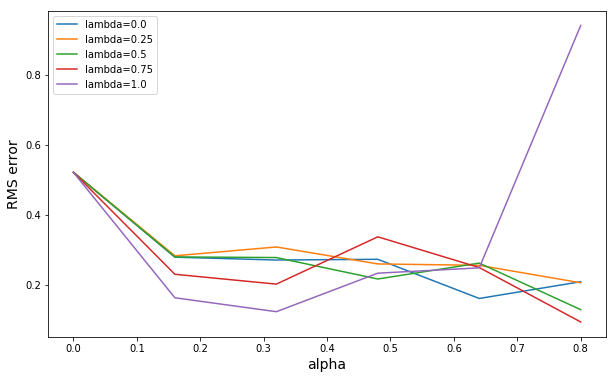

In [83]:
alphas = np.linspace(0, 0.8, 6)
lambdas = np.linspace(0, 1, 5)
rounds = 50

plt.figure(figsize=[10, 6])
for lamb in lambdas:
    alpha_erros = []
    for alpha in alphas:
        valueFunc = ValueFunctionTD(alpha=alpha, lmbda=lamb)
        rw = RWTD(debug=False)
        rw.play(valueFunc, rounds=rounds)
        rmse = np.sqrt(np.mean(np.power(valueFunc.weights - actual_state_values, 2)))
        print("lambda {} alpha {} rmse {}".format(lamb, alpha, rmse))
        alpha_erros.append(rmse)
    plt.plot(alphas, alpha_erros, label="lambda={}".format(lamb))

plt.xlabel("alpha", size=14)
plt.ylabel("RMS error", size=14)
plt.legend()